# Transfer Learning with MobileNetV2

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### DNN Model to decide is it alpaca or not

In [2]:
# Prepare Datasets

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


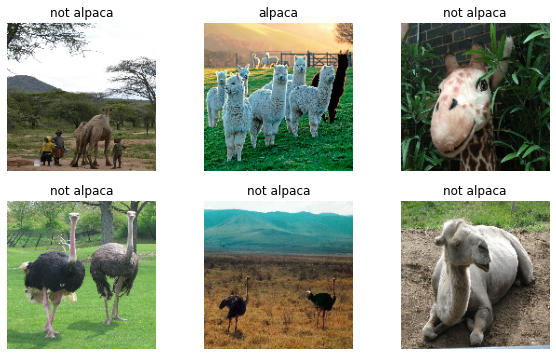

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 6))
for images, labels in train_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

#### Data Augmentation

In [9]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

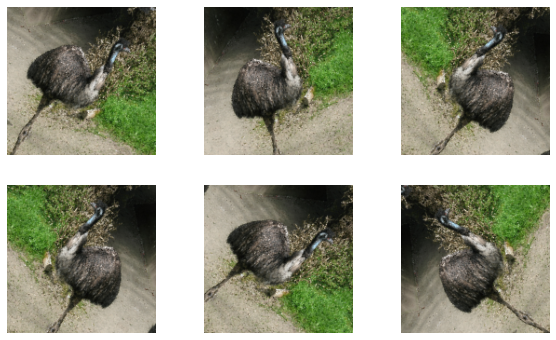

In [11]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 6))
    first_image = image[0]
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

<font color = 'blue'>

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

### MoblieNetV2
*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [29]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [51]:
base_model.trainable = False

image_batch, label_batch = next(iter(train_dataset))
pred = base_model(preprocess_input(image_batch))
tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n01518878', 'ostrich', 0.7931699), ('n02410509', 'bison', 0.08361345)],
 [('n07734744', 'mushroom', 0.04386675), ('n03017168', 'chime', 0.040110614)],
 [('n02437616', 'llama', 0.69123155), ('n02412080', 'ram', 0.030485146)],
 [('n02437616', 'llama', 0.78292173), ('n02415577', 'bighorn', 0.04114262)],
 [('n01883070', 'wombat', 0.22639108), ('n02442845', 'mink', 0.21543229)],
 [('n02113712', 'miniature_poodle', 0.14046422),
  ('n02437616', 'llama', 0.09130067)],
 [('n02415577', 'bighorn', 0.24294604), ('n02412080', 'ram', 0.16056636)],
 [('n02437616', 'llama', 0.50890934), ('n02412080', 'ram', 0.17243022)],
 [('n02437616', 'llama', 0.94984937),
  ('n02437312', 'Arabian_camel', 0.004765939)],
 [('n02437616', 'llama', 0.34926665), ('n01518878', 'ostrich', 0.18427768)],
 [('n02437616', 'llama', 0.94477606), ('n02423022', 'gazelle', 0.0054335343)],
 [('n02437312', 'Arabian_camel', 0.29541188),
  ('n02134084', 'ice_bear', 0.043125287)],
 [('n02437616', 'llama', 0.309349),
  ('n02437312', 

### Transfer Learning

In [53]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [54]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9420800/9406464 [==============================] - 2s 0us/step


In [57]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 5s 357ms/step - loss: 0.5491 - accuracy: 0.6870 - val_loss: 0.4893 - val_accuracy: 0.6615
Epoch 2/5
9/9 [==============================] - 3s 277ms/step - loss: 0.4827 - accuracy: 0.7405 - val_loss: 0.4115 - val_accuracy: 0.7077
Epoch 3/5
9/9 [==============================] - 3s 283ms/step - loss: 0.4223 - accuracy: 0.7710 - val_loss: 0.3463 - val_accuracy: 0.8154
Epoch 4/5
9/9 [==============================] - 3s 283ms/step - loss: 0.4130 - accuracy: 0.8015 - val_loss: 0.3187 - val_accuracy: 0.7692
Epoch 5/5
9/9 [==============================] - 3s 278ms/step - loss: 0.3790 - accuracy: 0.7786 - val_loss: 0.2865 - val_accuracy: 0.8769


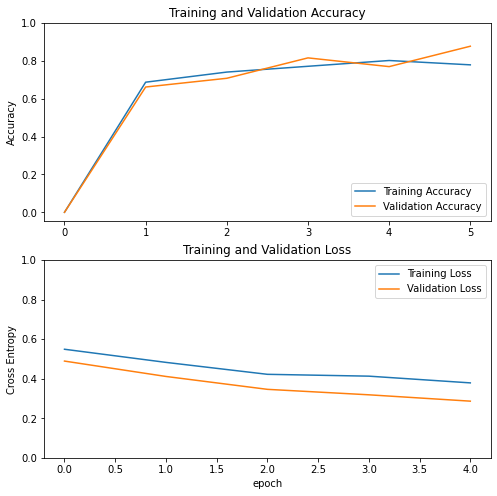

In [59]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Fine Tuning the model

In [61]:
base_model = model2.layers[4]
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [62]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 6s 395ms/step - loss: 0.5131 - accuracy: 0.7672 - val_loss: 0.3155 - val_accuracy: 0.7846
Epoch 6/10
9/9 [==============================] - 3s 322ms/step - loss: 0.3587 - accuracy: 0.8015 - val_loss: 0.2405 - val_accuracy: 0.8462
Epoch 7/10
9/9 [==============================] - 3s 322ms/step - loss: 0.2623 - accuracy: 0.8855 - val_loss: 0.1514 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 3s 325ms/step - loss: 0.1736 - accuracy: 0.9084 - val_loss: 0.0963 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 3s 325ms/step - loss: 0.1289 - accuracy: 0.9351 - val_loss: 0.0659 - val_accuracy: 0.9692
Epoch 10/10
9/9 [==============================] - 3s 324ms/step - loss: 0.1001 - accuracy: 0.9695 - val_loss: 0.0770 - val_accuracy: 0.9846


In [63]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

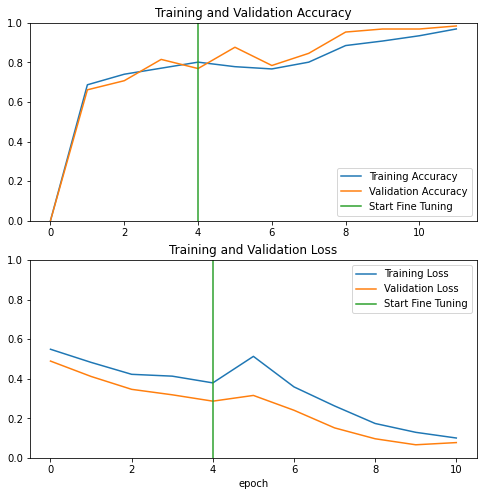

In [64]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 